In [1]:
import wikipedia, requests, random, pycm, json, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
from IPython.display import display, Markdown
from classification_procedure import ClassificationProcedure

## Classification procedures

In [2]:
oed_planet = ClassificationProcedure(
    "OED",
    "planet", 
    """Any of various rocky or gaseous bodies that revolve in approximately elliptical orbits 
around the sun and are visible by its reflected light; esp. each of the planets Mercury, Venus, 
Earth, Mars, Jupiter, Saturn, Uranus, Neptune, and (until 2006) Pluto (in order of increasing 
distance from the sun); a similar body revolving around another star. Also: any of various 
smaller bodies that revolve around these (cf. satellite n. 2a).""",
    "https://www.oed.com/dictionary/planet_n"
)

iau_2006_8_16_planet = ClassificationProcedure(
    "IAU 2006-08-16",
    "planet", 
    """A planet is a celestial body that (a) has sufficient mass for its self-gravity to 
overcome rigid body forces so that it assumes a hydrostatic equilibrium (nearly round) shape, 
and (b) is in orbit around a star, and is neither a star nor a satellite of a planet.""",
    "https://www.iau.org/news/pressreleases/detail/iau0601/"
)

iau_2006_8_24_planet = ClassificationProcedure(
    "IAU 2006-08-24",
    "planet", 
    """A planet [1] is a celestial body that (a) is in orbit around the Sun, (b) has sufficient 
mass for its self-gravity to overcome rigid body forces so that it assumes a hydrostatic 
equilibrium (nearly round) shape, and (c) has cleared the neighbourhood around its orbit.""",
    "https://www.iau.org/static/resolutions/Resolution_GA26-5-6.pdf"
)

### Example in Figure 1

In [3]:
iau_2006_8_24_planet.classify("DENIS-P J082303.1−491201 b", "DENIS-P J082303.1-491201 b (alias 2MASS J08230313-4912012 b) is a substellar object, classified as either an exoplanet or a brown dwarf, orbiting DENIS-P J082303.1-491201, an L1.5-type brown dwarf in the constellation Vela.")

{'concept': 'planet',
 'definition': 'A planet [1] is a celestial body that (a) is in orbit around the Sun, (b) has sufficient \nmass for its self-gravity to overcome rigid body forces so that it assumes a hydrostatic \nequilibrium (nearly round) shape, and (c) has cleared the neighbourhood around its orbit.',
 'entity': 'DENIS-P J082303.1−491201 b',
 'description': 'DENIS-P J082303.1-491201 b (alias 2MASS J08230313-4912012 b) is a substellar object, classified as either an exoplanet or a brown dwarf, orbiting DENIS-P J082303.1-491201, an L1.5-type brown dwarf in the constellation Vela.',
 'rationale': 'The description of DENIS-P J082303.1−491201 b indicates that it is a substellar object that orbits DENIS-P J082303.1-491201, which is similar to the first part of the definition of a planet that states it is a celestial body in orbit around the Sun. Although it is not specifically stated that DENIS-P J082303.1−491201 b is in orbit around the Sun, it can be inferred from the fact that it

## Wikidata queries

In [4]:
KNOWLEDGE_GRAPH = "https://query.wikidata.org/sparql"

QUERY_HEADERS = {
    'User-Agent': 'ConceptualEngineeringAgent/0.2 (https://github.com/bradleypallen/conceptual-engineering-using-llms; b.p.allen@uva.nl)',
}

SAMPLE_SIZE = 50

POSITIVE_EXAMPLES_QUERY = """SELECT DISTINCT ?entity ?name ?article WHERE {
  {
    ?entity p:P31/ps:P31/wdt:P279* wd:Q634 .
    ?article schema:about ?entity ;
            schema:inLanguage "en" ;
            schema:isPartOf <https://en.wikipedia.org/> ;
            schema:name ?name .
  }
} LIMIT 10000"""

NEGATIVE_EXAMPLES_QUERY = """SELECT DISTINCT ?entity ?name ?article WHERE {
  {
    ?entity p:P31/ps:P31/wdt:P279* wd:Q3132741 .
    ?article schema:about ?entity ;
            schema:inLanguage "en" ;
            schema:isPartOf <https://en.wikipedia.org/> ;
            schema:name ?name .
    FILTER NOT EXISTS { ?entity p:P31/ps:P31 wd:Q634 }
  }
} LIMIT 10000"""

## Example entities

In [5]:
response = requests.get(KNOWLEDGE_GRAPH, params={'query' : POSITIVE_EXAMPLES_QUERY, 'format' : 'json'}, headers=QUERY_HEADERS)
response.raise_for_status()
json_response = response.json()
records = [ [ result["entity"]["value"], result["name"]["value"], result["article"]["value"] ] for result in json_response["results"]["bindings"] ]
records = random.sample(records, 10*SAMPLE_SIZE)
records_with_pages = []
for record in records:
    try:
        page = wikipedia.page(record[1], auto_suggest=True)
        if not "List" in page.title and page.title == record[1]:
            records_with_pages.append(record)
    except Exception as e:
        pass
    if len(records_with_pages) == SAMPLE_SIZE:
        break
positive_examples = pd.DataFrame.from_records(records_with_pages, columns=["id", "name", "article"])
positive_examples["description"] = positive_examples["name"].apply(lambda name: wikipedia.summary(name, auto_suggest=False).replace('"', r'\"').strip()) 
positive_examples["actual"] = "positive"

/Users/bradleyallen/Documents/GitHub/conceptual-engineering-using-llms/lib/python3.11/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/bradleyallen/Documents/GitHub/conceptual-engineering-using-llms/lib/python3.11/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [6]:
response = requests.get(KNOWLEDGE_GRAPH, params={'query' : NEGATIVE_EXAMPLES_QUERY, 'format' : 'json'}, headers=QUERY_HEADERS)
response.raise_for_status()
json_response = response.json()
records = [ [ result["entity"]["value"], result["name"]["value"], result["article"]["value"] ] for result in json_response["results"]["bindings"] ]
records = random.sample(records, 10*SAMPLE_SIZE)
records_with_pages = []
for record in records:
    try:
        page = wikipedia.page(record[1], auto_suggest=True)
        if not "List" in page.title and page.title == record[1]:
            records_with_pages.append(record)
    except Exception as e:
        pass
    if len(records_with_pages) == SAMPLE_SIZE:
        break
negative_examples = pd.DataFrame.from_records(records_with_pages, columns=["id", "name", "article"])
negative_examples["description"] = negative_examples["name"].apply(lambda name: wikipedia.summary(name, auto_suggest=False).replace('"', r'\"').strip()) 
negative_examples["actual"] = "negative"

/Users/bradleyallen/Documents/GitHub/conceptual-engineering-using-llms/lib/python3.11/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/bradleyallen/Documents/GitHub/conceptual-engineering-using-llms/lib/python3.11/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [7]:
examples = pd.concat([positive_examples, negative_examples], ignore_index=True)
examples

,id,name,article,description,actual
0,http://www.wikidata.org/entity/Q81282,HD 187123 b,https://en.wikipedia.org/wiki/HD_187123_b,"HD 187123 b is a typical \""hot Jupiter\"" locat...",positive
1,http://www.wikidata.org/entity/Q276894,94 Ceti b,https://en.wikipedia.org/wiki/94_Ceti_b,94 Ceti b or 94 Ceti Ab to distinguish it from...,positive
2,http://www.wikidata.org/entity/Q83773,HD 82943 b,https://en.wikipedia.org/wiki/HD_82943_b,HD 82943 b is an extrasolar planet approximate...,positive
3,http://www.wikidata.org/entity/Q19672936,Kepler-56b,https://en.wikipedia.org/wiki/Kepler-56b,Kepler-56b (KOI-1241.02) is a hot Neptune—a cl...,positive
4,http://www.wikidata.org/entity/Q1578873,Tau Ceti f,https://en.wikipedia.org/wiki/Tau_Ceti_f,Tau Ceti f is a super-Earth or mini-Neptune or...,positive
...,...,...,...,...,...
95,http://www.wikidata.org/entity/Q1774712,Great Comet of 1744,https://en.wikipedia.org/wiki/Great_Comet_of_1744,"The Great Comet of 1744, whose official design...",negative
96,http://www.wikidata.org/entity/Q2533763,Kosmos 1402,https://en.wikipedia.org/wiki/Kosmos_1402,Kosmos 1402 (Russian: Космос 1402) was a Sovie...,negative
97,http://www.wikidata.org/entity/Q149226,249 Ilse,https://en.wikipedia.org/wiki/249_Ilse,Ilse (minor planet designation: 249 Ilse) is a...,negative
98,http://www.wikidata.org/entity/Q12270325,Kosmos 104,https://en.wikipedia.org/wiki/Kosmos_104,Kosmos 104 (Космос 104 meaning Cosmos 104) or ...,negative


## Experiments

In [8]:
def run_experiment(cp, examples):
    classifications = examples.to_dict("records")
    for entity in tqdm(classifications):
        classification = cp.classify(entity["name"], entity["description"])
        entity["rationale"] = classification["rationale"]
        entity["predicted"] = classification["answer"]
    return pd.DataFrame.from_records(classifications)

In [9]:
oed_planet_results = run_experiment(oed_planet, examples)

100%|██████████| 100/100 [13:17<00:00,  7.97s/it]


In [10]:
iau_2006_8_16_planet_results = run_experiment(iau_2006_8_16_planet, examples)

100%|██████████| 100/100 [12:54<00:00,  7.74s/it]


In [11]:
iau_2006_8_24_planet_results = run_experiment(iau_2006_8_24_planet, examples)

100%|██████████| 100/100 [13:30<00:00,  8.10s/it]


## Performance metrics

In [12]:
oed_planet_cm = pycm.ConfusionMatrix(
    oed_planet_results["actual"].tolist(), 
    oed_planet_results["predicted"].tolist(), 
    digit=2, 
    classes=[ 'positive', 'negative' ]
)

iau_2006_8_16_planet_cm = pycm.ConfusionMatrix(
    iau_2006_8_16_planet_results["actual"].tolist(), 
    iau_2006_8_16_planet_results["predicted"].tolist(), 
    digit=2, 
    classes=[ 'positive', 'negative' ]
)

iau_2006_8_24_planet_cm = pycm.ConfusionMatrix(
    iau_2006_8_24_planet_results["actual"].tolist(), 
    iau_2006_8_24_planet_results["predicted"].tolist(), 
    digit=2, 
    classes=[ 'positive', 'negative' ]
)

In [13]:
cms = [
    (f'{oed_planet.term} ({oed_planet.id})', oed_planet_cm),
    (f'{iau_2006_8_16_planet.term} ({iau_2006_8_16_planet.id})', iau_2006_8_16_planet_cm),
    (f'{iau_2006_8_24_planet.term} ({iau_2006_8_24_planet.id})', iau_2006_8_24_planet_cm)
]

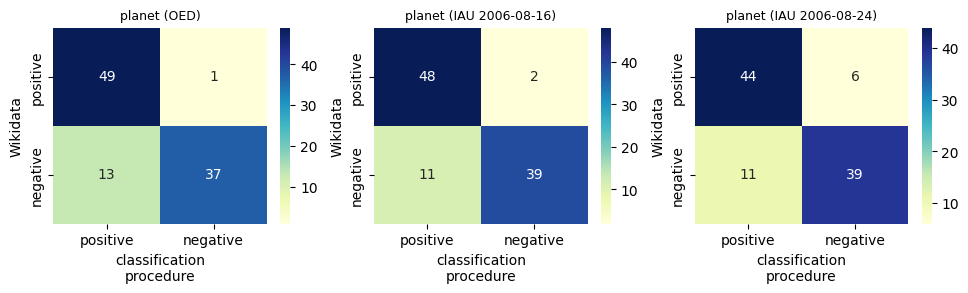

In [14]:
fig = plt.figure(figsize=(20,14))
gs = fig.add_gridspec(4, 5, hspace=0.5)
axes = gs.subplots()
for ax, (name, cm) in zip(axes.flat, cms):
    df = pd.DataFrame(cm.matrix).T.fillna(0)
    sns.heatmap(df, annot=True, fmt='d', cmap="YlGnBu", ax=ax)
    ax.set_title(name, wrap=True, fontsize=9)
    ax.set(xlabel='classification\nprocedure', ylabel='Wikidata')
for ax in axes.flat[len(cms):]:
    ax.set_visible(False)
plt.show()

In [15]:
metrics = pd.DataFrame.from_records([ 
    { "classification procedure": cm[0], "Cohen's kappa": cm[1].Kappa, "F1 macro": cm[1].F1_Macro, "FN": cm[1].FN["positive"], "FP": cm[1].FP["positive"] }
    for cm in cms 
])
metrics.sort_values(by="Cohen's kappa", ascending=False)

,classification procedure,Cohen's kappa,F1 macro,FN,FP
1,planet (IAU 2006-08-16),0.74,0.868938,2,11
0,planet (OED),0.72,0.857955,1,13
2,planet (IAU 2006-08-24),0.66,0.829574,6,11


## Error analyses

In [16]:
def display_errors(cp, results):
    display(Markdown(f'### {cp.term} ({cp.id})'))
    display(Markdown(f'#### Definition'))
    display(Markdown(f'{cp.definition}'))
    fns = results[((results["actual"] == 'positive') & (results["predicted"] == 'negative'))][["name", "description", "rationale"]]
    if len(fns) > 0:
        fns_styler = fns.style.set_properties(**{"text-align": "left", "vertical-align" : "top", "overflow-wrap": "break-word"}).hide(axis="index")
        display(Markdown(f'#### False negatives'))
        display(fns_styler)
    fps = results[((results["actual"] == 'negative') & (results["predicted"] == 'positive'))][["name", "description", "rationale"]]
    if len(fps) > 0:
        fps_styler = fps.style.set_properties(**{"text-align": "left", "vertical-align" : "top", "overflow-wrap": "break-word"}).hide(axis="index")
        display(Markdown(f'#### False positives'))
        display(fps_styler)


In [17]:
display_errors(oed_planet, oed_planet_results)

### planet (OED)

#### Definition

Any of various rocky or gaseous bodies that revolve in approximately elliptical orbits 
around the sun and are visible by its reflected light; esp. each of the planets Mercury, Venus, 
Earth, Mars, Jupiter, Saturn, Uranus, Neptune, and (until 2006) Pluto (in order of increasing 
distance from the sun); a similar body revolving around another star. Also: any of various 
smaller bodies that revolve around these (cf. satellite n. 2a).

#### False negatives

name,description,rationale
WISE 1828+2650,"WISE 1828+2650 (full designation WISEPA J182831.08+265037.8) is a possibly binary brown dwarf or rogue planet of spectral class >Y2, located in constellation Lyra at approximately 32.5 light-years from Earth. It is the \""archetypal member\"" of the Y spectral class.","WISE 1828+2650 could be considered a planet based on the definition provided. The definition states that a planet can be a body that revolves around another star, which is a characteristic that could apply to WISE 1828+2650. Although it is not explicitly stated that WISE 1828+2650 revolves around a star, it is located in a constellation, which suggests that it is part of a star system. Furthermore, the definition includes smaller bodies that revolve around these planets, which could apply to WISE 1828+2650 if it is indeed a binary brown dwarf. Therefore, based on the provided definition, there is a plausible argument for classifying WISE 1828+2650 as a planet."


#### False positives

name,description,rationale
Gliese 176 b,"Gliese 176 b is a super-Earth exoplanet approximately 31 light years away in the constellation of Taurus. This planet orbits very close to its parent red dwarf star Gliese 176 (also called \""HD 285968\""). The initial announcement confused the planetary periodicity with the stellar periodicity of 40 days, thus giving a 10.24 day period for a 25 Earth-mass planet. Subsequent readings filtered out the star's rotation, giving a more accurate reading of the planet's orbit and minimum mass. The planet orbits inside the inner magnetosphere of its star. The quoted temperature of 450 K is a \""thermal equilibrium\"" temperature.It is projected to be dominated by a rocky core, but the true mass is unknown. If the orbit is oriented such that we are viewing it at a nearly face-on angle, the planet may be significantly more massive than the lower limit. If so, it may have attracted a gas envelope like Uranus or Gliese 436 b.","Gliese 176 b fits the definition of a planet as it is a body that revolves in an orbit around a star, in this case, the red dwarf star Gliese 176. It is visible by the reflected light of its star. Although it is not one of the planets in our solar system, the definition allows for similar bodies revolving around other stars, which is the case for Gliese 176 b. Furthermore, it is suggested that Gliese 176 b may have a rocky core, which aligns with the definition's allowance for rocky bodies. Therefore, based on the provided definition, Gliese 176 b can be classified as a planet."
HD 10180 c,"HD 10180 c is an exoplanet approximately 130 light-years away in the constellation Hydrus. It was discovered in 2010 using the radial velocity method. With a minimum mass comparable to that of Neptune, it is of the class of planets known as Hot Neptunes. Dynamical simulations suggest that if the mass gradient was any more than a factor of two, the system would not be stable. While planet c does not exist in any mean motion resonances, both planets with adjacent orbits (b and d) share near resonances with c.","HD 10180 c fits the definition of a planet as it is a body that revolves around a star, in this case, the star HD 10180. It is visible by its reflected light and has an elliptical orbit, similar to the planets in our solar system. It also has a mass comparable to that of Neptune, one of the planets mentioned in the definition. Furthermore, it is referred to as an exoplanet, which is a term used to describe planets that orbit a star outside of our solar system. Therefore, based on the provided definition, HD 10180 c can be classified as a planet."
(523719) 2014 LM28,"(523719) 2014 LM28, provisional designation 2014 LM28, is a trans-Neptunian object and centaur, approximately 46 kilometers (29 miles) in diameter. It was discovered on 16 May 2013, by the Pan-STARRS 1 survey at Haleakala Observatory, Hawaii, United States. The object's orbit is highly inclined and very eccentric, with a perihelion closer to the Sun than Uranus and at an aphelion 17 times farther from the Sun than Neptune.","(523719) 2014 LM28 can be considered a planet based on the definition provided. The definition states that a planet is a rocky or gaseous body that revolves in approximately elliptical orbits around the sun and is visible by its reflected light. The description of (523719) 2014 LM28 indicates that it is a trans-Neptunian object and centaur, which are types of celestial bodies, and it revolves around the sun in a highly inclined and very eccentric orbit. Furthermore, it is visible by the sun's reflected light. Therefore, based on the provided definition, (523719) 2014 LM28 can be argued to be a planet."
HD 11964 c,"HD 11964 c is an extrasolar planet approximately 110 light-years away in the constellation of Cetus. The planet was discovered in a close-orbit around the yellow subgiant star HD 11964. The planet has a minimum mass 35 times the mass of Earth and is located in a mildly eccentric orbit which 

In [18]:
display_errors(iau_2006_8_16_planet, iau_2006_8_16_planet_results)

### planet (IAU 2006-08-16)

#### Definition

A planet is a celestial body that (a) has sufficient mass for its self-gravity to 
overcome rigid body forces so that it assumes a hydrostatic equilibrium (nearly round) shape, 
and (b) is in orbit around a star, and is neither a star nor a satellite of a planet.

#### False negatives

name,description,rationale
MOA-2011-BLG-262Lb,"MOA-2011-BLG-262Lb is a Neptune-sized planet or possibly an exomoon orbiting the red dwarf or potentially rogue planet MOA-2011-BLG-262L. If it is an exomoon, then it would be around the size of Mars.","The description of MOA-2011-BLG-262Lb suggests that it is a celestial body that is in orbit around a star or potentially a rogue planet. This aligns with part (b) of the definition of a planet, which states that a planet is in orbit around a star and is neither a star nor a satellite of a planet. The description also suggests that MOA-2011-BLG-262Lb has a sufficient mass to assume a hydrostatic equilibrium (nearly round) shape, which aligns with part (a) of the definition. Therefore, based on the provided definition, it can be argued that MOA-2011-BLG-262Lb is a planet. However, the assertion that it could be an exomoon introduces some uncertainty, as the definition specifies that a planet is not a satellite of another planet."
Kolob,"Kolob is a star or planet described in the Book of Abraham, a sacred text of the Latter Day Saint movement. Several Latter Day Saint denominations hold the Book of Abraham to have been translated from an Egyptian papyrus scroll by Joseph Smith, the founder of the movement. According to this work, Kolob is the heavenly body nearest to the throne of God. While the Book of Abraham calls Kolob a \""star\"", it also calls planets \""stars\"", and therefore some Latter Day Saint commentators consider Kolob a planet. The body also appears in Latter Day Saint culture, including a reference to Kolob in an LDS hymn.","The Book of Abraham, a sacred text of the Latter Day Saint movement, describes Kolob as a celestial body that is neither a star nor a satellite of a planet. While it is referred to as a ""star"", the text also uses the term ""star"" to describe planets. Therefore, it is possible that Kolob is a planet. Furthermore, the text states that Kolob is the heavenly body nearest to the throne of God, suggesting it is in orbit around a star, which aligns with the definition of a planet. However, without further information about its mass and shape, it cannot be definitively concluded that Kolob is a planet."


#### False positives

name,description,rationale
Gliese 176 b,"Gliese 176 b is a super-Earth exoplanet approximately 31 light years away in the constellation of Taurus. This planet orbits very close to its parent red dwarf star Gliese 176 (also called \""HD 285968\""). The initial announcement confused the planetary periodicity with the stellar periodicity of 40 days, thus giving a 10.24 day period for a 25 Earth-mass planet. Subsequent readings filtered out the star's rotation, giving a more accurate reading of the planet's orbit and minimum mass. The planet orbits inside the inner magnetosphere of its star. The quoted temperature of 450 K is a \""thermal equilibrium\"" temperature.It is projected to be dominated by a rocky core, but the true mass is unknown. If the orbit is oriented such that we are viewing it at a nearly face-on angle, the planet may be significantly more massive than the lower limit. If so, it may have attracted a gas envelope like Uranus or Gliese 436 b.","Gliese 176 b fits the definition of a planet as it is a celestial body that has sufficient mass to assume a hydrostatic equilibrium shape, as indicated by the description stating it is projected to be dominated by a rocky core. This suggests that its self-gravity has overcome rigid body forces to form a nearly round shape. Additionally, Gliese 176 b is in orbit around a star, specifically the red dwarf star Gliese 176, which aligns with the second part of the definition. The description does not classify Gliese 176 b as a star or a satellite of a planet, further supporting the assertion that it is a planet."
HD 10180 c,"HD 10180 c is an exoplanet approximately 130 light-years away in the constellation Hydrus. It was discovered in 2010 using the radial velocity method. With a minimum mass comparable to that of Neptune, it is of the class of planets known as Hot Neptunes. Dynamical simulations suggest that if the mass gradient was any more than a factor of two, the system would not be stable. While planet c does not exist in any mean motion resonances, both planets with adjacent orbits (b and d) share near resonances with c.","HD 10180 c fits the definition of a planet because it is a celestial body that is in orbit around a star, specifically the star HD 10180. The description does not explicitly state that HD 10180 c has a nearly round shape due to its self-gravity overcoming rigid body forces, but it is implied by the fact that it is classified as a Hot Neptune, a class of planets. Furthermore, it is not described as a star or a satellite of a planet, which further supports the assertion that HD 10180 c is a planet."
HD 11964 c,"HD 11964 c is an extrasolar planet approximately 110 light-years away in the constellation of Cetus. The planet was discovered in a close-orbit around the yellow subgiant star HD 11964. The planet has a minimum mass 35 times the mass of Earth and is located in a mildly eccentric orbit which takes almost 38 days to complete. HD 11964 c was a possible planet discovered on the same day as HD 11964 b in 2005. HD 11964 c was first proposed in a paper published in 2007, and finally confirmed with new data presented in a review of multi-planet systems which appeared on the arXiv preprint website in 2008.Some sources have used the designation \""HD 11964 b\"" for this planet, however in their review of the properties of multi-planet extrasolar planetary systems, the discovery team has stated that the correct designation for this planet is HD 11964 c and the reversed system was due to confusion related to private communications between various groups of astronomers.","HD 11964 c fits the definition of a planet as it is a celestial body that is in orbit around a star, specifically the yellow subgiant star HD 11964. The description does not provide explicit information about its shape, but given that it has a minimum mass 35 times the mass of Earth, it can be inferred that it has sufficient mass for its self-gravity to overcome rigid body forces and assume a h

In [19]:
display_errors(iau_2006_8_24_planet, iau_2006_8_24_planet_results)

### planet (IAU 2006-08-24)

#### Definition

A planet [1] is a celestial body that (a) is in orbit around the Sun, (b) has sufficient 
mass for its self-gravity to overcome rigid body forces so that it assumes a hydrostatic 
equilibrium (nearly round) shape, and (c) has cleared the neighbourhood around its orbit.

#### False negatives

name,description,rationale
HD 4313 b,HD 4313 b is an extrasolar planet orbiting the K-type star HD 4313 approximately 447 light years away in the constellation Pisces. This planet was discovered using the Doppler spectroscopy (radial velocity) method.,"The definition of a planet states that it must be a celestial body that is in orbit around the Sun, has sufficient mass for its self-gravity to overcome rigid body forces so that it assumes a hydrostatic equilibrium (nearly round) shape, and has cleared the neighbourhood around its orbit. The description of HD 4313 b indicates that it is an extrasolar planet orbiting a star (HD 4313). Although it does not specifically state that HD 4313 b has sufficient mass to overcome rigid body forces and assume a nearly round shape, or that it has cleared its orbit, the fact that it is referred to as a ""planet"" suggests that it meets these criteria. However, the definition specifies that a planet must be in orbit around the Sun, while HD 4313 b is in orbit around a different star. Therefore, based strictly on the provided definition, it could be argued that HD 4313 b is not a planet. This highlights a limitation in the provided definition, as it does not account for the existence of extrasolar planets, which are widely recognized by the scientific community. A more inclusive definition would specify that a planet is a celestial body that orbits a star (not necessarily the Sun), has sufficient mass to assume a nearly round shape, and has cleared its orbit."
SDSS J1228+1040 b,SDSS J1228+1040 b is an extrasolar planetesimal orbiting the white dwarf SDSS J1228+1040.,"The definition provided states that a planet is a celestial body that orbits the Sun, has sufficient mass to maintain a nearly round shape due to its self-gravity, and has cleared the neighbourhood around its orbit. However, the description of SDSS J1228+1040 b only provides information that it is an extrasolar planetesimal orbiting a white dwarf, not the Sun. Therefore, based solely on the provided definition and description, it cannot be definitively argued that SDSS J1228+1040 b is a planet."
MOA-2011-BLG-262Lb,"MOA-2011-BLG-262Lb is a Neptune-sized planet or possibly an exomoon orbiting the red dwarf or potentially rogue planet MOA-2011-BLG-262L. If it is an exomoon, then it would be around the size of Mars.","The assertion that MOA-2011-BLG-262Lb is a planet can be supported by the given definition if we assume that it meets all the criteria. The description states that MOA-2011-BLG-262Lb is in orbit around the red dwarf or potentially rogue planet MOA-2011-BLG-262L, which could be interpreted as being in orbit around the Sun if the red dwarf or rogue planet is itself in orbit around the Sun. The description also suggests that MOA-2011-BLG-262Lb has sufficient mass to assume a nearly round shape, as it is described as being Neptune-sized or possibly Mars-sized. However, the description does not provide information on whether MOA-2011-BLG-262Lb has cleared the neighbourhood around its orbit, which is a necessary criterion for being classified as a planet according to the given definition. Therefore, based on the available information, it can be argued that MOA-2011-BLG-262Lb could potentially be a planet, but further information would be needed to confirm this."
Kolob,"Kolob is a star or planet described in the Book of Abraham, a sacred text of the Latter Day Saint movement. Several Latter Day Saint denominations hold the Book of Abraham to have been translated from an Egyptian papyrus scroll by Joseph Smith, the founder of the movement. According to this work, Kolob is the heavenly body nearest to the throne of God. While the Book of Abraham calls Kolob a \""star\"", it also calls planets \""stars\"", and therefore some Latter Day Saint commentators consider Kolob a planet. The body also appears in Latter Day Saint culture, including a reference to Kolob in an LDS hymn.","The Book of Abraham, a sacred text of the Latter Day S

#### False positives

name,description,rationale
Gliese 176 b,"Gliese 176 b is a super-Earth exoplanet approximately 31 light years away in the constellation of Taurus. This planet orbits very close to its parent red dwarf star Gliese 176 (also called \""HD 285968\""). The initial announcement confused the planetary periodicity with the stellar periodicity of 40 days, thus giving a 10.24 day period for a 25 Earth-mass planet. Subsequent readings filtered out the star's rotation, giving a more accurate reading of the planet's orbit and minimum mass. The planet orbits inside the inner magnetosphere of its star. The quoted temperature of 450 K is a \""thermal equilibrium\"" temperature.It is projected to be dominated by a rocky core, but the true mass is unknown. If the orbit is oriented such that we are viewing it at a nearly face-on angle, the planet may be significantly more massive than the lower limit. If so, it may have attracted a gas envelope like Uranus or Gliese 436 b.","Gliese 176 b can be considered a planet based on the provided definition. Firstly, it is in orbit around a star, specifically the red dwarf star Gliese 176. Secondly, it is described as a super-Earth exoplanet, which implies it has sufficient mass for its self-gravity to overcome rigid body forces and assume a hydrostatic equilibrium shape. Lastly, while the description does not explicitly state that Gliese 176 b has cleared its orbit, the fact that it has a defined orbit and minimum mass suggests that it has likely cleared its neighbourhood around its orbit. Therefore, Gliese 176 b meets the criteria to be classified as a planet."
HD 10180 c,"HD 10180 c is an exoplanet approximately 130 light-years away in the constellation Hydrus. It was discovered in 2010 using the radial velocity method. With a minimum mass comparable to that of Neptune, it is of the class of planets known as Hot Neptunes. Dynamical simulations suggest that if the mass gradient was any more than a factor of two, the system would not be stable. While planet c does not exist in any mean motion resonances, both planets with adjacent orbits (b and d) share near resonances with c.","HD 10180 c can be considered a planet based on the provided definition. Firstly, it is a celestial body that is in orbit around a star, similar to how planets orbit the Sun. Secondly, it has a mass comparable to that of Neptune, which suggests it has sufficient mass for its self-gravity to overcome rigid body forces and assume a hydrostatic equilibrium shape. Lastly, the mention of its stable system and near resonances with adjacent orbits suggests that it has cleared its neighbourhood around its orbit. Therefore, HD 10180 c meets all the criteria in the definition of a planet."
HD 11964 c,"HD 11964 c is an extrasolar planet approximately 110 light-years away in the constellation of Cetus. The planet was discovered in a close-orbit around the yellow subgiant star HD 11964. The planet has a minimum mass 35 times the mass of Earth and is located in a mildly eccentric orbit which takes almost 38 days to complete. HD 11964 c was a possible planet discovered on the same day as HD 11964 b in 2005. HD 11964 c was first proposed in a paper published in 2007, and finally confirmed with new data presented in a review of multi-planet systems which appeared on the arXiv preprint website in 2008.Some sources have used the designation \""HD 11964 b\"" for this planet, however in their review of the properties of multi-planet extrasolar planetary systems, the discovery team has stated that the correct designation for this planet is HD 11964 c and the reversed system was due to confusion related to private communications between various groups of astronomers.","HD 11964 c can be considered a planet based on the provided definition. Firstly, it is in orbit around a star, specifically the yellow subgiant star HD 11964, which is similar to the requirement of being in orbit around the Sun. Secondly, it has a minimum mass 35 times the mass of Earth, w

## Experimental results data dump

In [20]:
EXPERIMENTS_FILENAME = "planet_experiment.json"

experiments = [
    {
        "classification_procedure": {
            "id": cp.id,
            "term": cp.term,
            "definition": cp.definition,
            "reference": cp.reference,
            "model_name": cp.model_name,
            "temperature": cp.temperature
        },
        "results": results.to_dict("records")
    } for cp, results in [
        (oed_planet, oed_planet_results),
        (iau_2006_8_16_planet, iau_2006_8_16_planet_results),
        (iau_2006_8_24_planet, iau_2006_8_24_planet_results)
    ]
]

json.dump(experiments, open(EXPERIMENTS_FILENAME, 'w+'))